In [58]:

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scikeras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from sklearn.model_selection import train_test_split
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster


In [72]:
spyticker = yf.Ticker("SPY")
df_SPY = spyticker.history(period="max", interval="1d", start="2002-01-01", end="2022-12-31" , auto_adjust=True, rounding=True)
df_SPY['Date']=df_SPY.index
df_SPY=df_SPY.reset_index(drop='True')
df1=df_SPY['Date'].astype('str').str.split(' ',expand=True)
df1['Date']=df1[0]
df=pd.concat([df1['Date'],df_SPY['Close']],axis=1)
print(df)

            Date   Close
0     2002-01-02   76.90
1     2002-01-03   77.78
2     2002-01-04   78.30
3     2002-01-07   77.74
4     2002-01-08   77.56
...          ...     ...
5282  2022-12-23  380.04
5283  2022-12-27  378.54
5284  2022-12-28  373.84
5285  2022-12-29  380.57
5286  2022-12-30  379.57

[5287 rows x 2 columns]


In [3]:
def SPYt(df):
    new_column=[]
    b=0
    for i,row in df.iterrows():
        if i!=0:
            a=(row['Close']-b)/b
            b=row['Close']
        else:
            a=1
            b=row['Close']
        new_column.append(a)
    t1=[1]
    t1=t1+new_column
    t1.pop()
    t2=[1]
    t2=t2+t1
    t2.pop()
    t3=[1]
    t3=t3+t1
    t3.pop()
    df.insert(len(df.columns),'SPYt',new_column)
    df.insert(len(df.columns),'SPYt1',t1)
    df.insert(len(df.columns),'SPYt2',t2)
    df.insert(len(df.columns),'SPYt3',t3)
    return df

In [4]:
def SMA(df):
    df['SMA5']=df['Close'].rolling(window=5, min_periods=1, center=False).mean()
    df['SMA10']=df['Close'].rolling(window=10, min_periods=1, center=False).mean()
    df['SMA20']=df['Close'].rolling(window=20, min_periods=1, center=False).mean()
    df['SMA50']=df['Close'].rolling(window=50, min_periods=1, center=False).mean()
    return df


In [5]:
def USD_JPY_data(df):
    data=pd.read_csv('USD_JPY Historical Data.csv')
    data['Date1'] = pd.to_datetime(data['Date'].astype('datetime64[ns]'), format='%Y%m%d')
    data1=data['Date1'].astype('str').str.split(' ',expand=True)
    data1['Date1']=data1[0]
    data2=pd.concat([data1['Date1'],data['Price']],axis=1)
    data2.rename(columns={'Price': 'USD_JPY'}, inplace=True)
    data2.index=data1['Date1']
    data2.drop('Date1', axis=1, inplace=True)
    df.index=df['Date']
    df_new=pd.concat([df,data2],axis=1,join='inner')
    return df_new

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
def df_split(df): 
    test_split=round(len(df)*0.20)
    df_for_training=df[:-test_split]
    df_for_testing=df[-test_split:]
    df_for_training_scaled = scaler.fit_transform(df_for_training)
    df_for_testing_scaled=scaler.transform(df_for_testing)
    return df_for_training_scaled,df_for_testing_scaled

In [73]:
df=SPYt(df)
df=SMA(df)
#df=USD_JPY_data(df)

In [74]:
df

,Date,Close,SPYt,SPYt1,SPYt2,SPYt3,SMA5,SMA10,SMA20,SMA50
0,2002-01-02,76.90,1.000000,1.000000,1.000000,1.000000,76.900,76.900,76.9000,76.9000
1,2002-01-03,77.78,0.011443,1.000000,1.000000,1.000000,77.340,77.340,77.3400,77.3400
2,2002-01-04,78.30,0.006686,0.011443,1.000000,1.000000,77.660,77.660,77.6600,77.6600
3,2002-01-07,77.74,-0.007152,0.006686,0.011443,0.011443,77.680,77.680,77.6800,77.6800
4,2002-01-08,77.56,-0.002315,-0.007152,0.006686,0.006686,77.656,77.656,77.6560,77.6560
...,...,...,...,...,...,...,...,...,...,...
5282,2022-12-23,380.04,0.005743,-0.014269,0.014959,0.014959,379.222,384.734,389.4285,383.3890
5283,2022-12-27,378.54,-0.003947,0.005743,-0.014269,-0.014269,379.496,383.173,388.7980,383.8932
5284,2022-12-28,373.84,-0.012416,-0.003947,0.005743,0.005743,378.726,380.843,387.9660,384.1218
5285,2022-12-29,380.57,0.018002,-0.012416,-0.003947,-0.003947,378.172,379.440,386.8555,384.3998


In [75]:
df.drop('Date', axis=1, inplace=True)
df=df.drop(labels='2012-01-03',axis=0)
df=df.drop(labels='2012-01-04',axis=0)
df=df.drop(labels='2012-01-05',axis=0)

KeyError: "['2012-01-03'] not found in axis"

In [76]:
print(df)

       Close      SPYt     SPYt1     SPYt2     SPYt3     SMA5    SMA10  \
0      76.90  1.000000  1.000000  1.000000  1.000000   76.900   76.900   
1      77.78  0.011443  1.000000  1.000000  1.000000   77.340   77.340   
2      78.30  0.006686  0.011443  1.000000  1.000000   77.660   77.660   
3      77.74 -0.007152  0.006686  0.011443  0.011443   77.680   77.680   
4      77.56 -0.002315 -0.007152  0.006686  0.006686   77.656   77.656   
...      ...       ...       ...       ...       ...      ...      ...   
5282  380.04  0.005743 -0.014269  0.014959  0.014959  379.222  384.734   
5283  378.54 -0.003947  0.005743 -0.014269 -0.014269  379.496  383.173   
5284  373.84 -0.012416 -0.003947  0.005743  0.005743  378.726  380.843   
5285  380.57  0.018002 -0.012416 -0.003947 -0.003947  378.172  379.440   
5286  379.57 -0.002628  0.018002 -0.012416 -0.012416  378.512  378.903   

         SMA20     SMA50  
0      76.9000   76.9000  
1      77.3400   77.3400  
2      77.6600   77.6600  
3  

In [10]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
train,test=df_split(df)
trainX,trainY=createXY(train,30)
testX,testY=createXY(test,30)

In [11]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2182, 30, 10)
(2182,)
(523, 30, 10)
(523,)


In [12]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,10)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
 
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
#grid_model = KerasRegressor(model=build_model,optimizer='rmsprop', verbose=False,)
parameters = {
    'batch_size': [16],
    'epochs': [10],
    'optimizer' : ['adam'],
}
#parameters = {'batch_size' : ([16]), 'epochs' : ([8]),  'optimizer' : (['adam'])}
#parameters=dict(batch_size=[16,20],epochs=[8,10],optimizer=['adam','Adadelta'])
grid_search = GridSearchCV(estimator = grid_model,
                          param_grid = parameters)

C:\Users\MSI-NB\AppData\Local\Temp\ipykernel_55172\4088561817.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))


In [422]:
%time
grid_search = grid_search.fit(trainX,trainY)
my_model=grid_search.best_estimator_.model

Epoch 1/10
110/110 [==============================] - 11s 41ms/step - loss: 0.0092 - val_loss: 0.0185
Epoch 2/10
110/110 [==============================] - 3s 30ms/step - loss: 0.0030 - val_loss: 0.0160
Epoch 3/10
110/110 [==============================] - 3s 31ms/step - loss: 0.0025 - val_loss: 0.0070
Epoch 4/10
110/110 [==============================] - 3s 31ms/step - loss: 0.0026 - val_loss: 0.0053
Epoch 5/10
110/110 [==============================] - 3s 32ms/step - loss: 0.0022 - val_loss: 0.0168
Epoch 6/10
110/110 [==============================] - 3s 32ms/step - loss: 0.0022 - val_loss: 0.0356
Epoch 7/10
110/110 [==============================] - 3s 31ms/step - loss: 0.0025 - val_loss: 0.0107
Epoch 8/10
110/110 [==============================] - 4s 33ms/step - loss: 0.0022 - val_loss: 0.0115
Epoch 9/10
110/110 [==============================] - 3s 31ms/step - loss: 0.0017 - val_loss: 0.0126
Epoch 10/10
28/28 [==============================] - 0s 10ms/step - loss: 7.1199e-05
Epoch

In [423]:
prediction=my_model.predict(testX)
prediction_copies_array = np.repeat(prediction,10, axis=-1)
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),10)))[:,0]

train_preict=my_model.predict(trainX)
train_copy = np.repeat(train_preict,10, axis=-1)
train_pred=scaler.inverse_transform(np.reshape(train_copy,(len(train_preict),10)))[:,0]

original_copies_array = np.repeat(testY,10, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),10)))[:,0]

69/69 [==============================] - 1s 16ms/step


In [427]:
array1 = np.ones(30)
whole_pred=np.concatenate((array1, pred), axis=0)
whole_train=np.concatenate((array1, train_pred), axis=0)
lstm_pred=np.concatenate((whole_pred, whole_train), axis=0)

array([  1.        ,   1.        ,   1.        , ..., 342.60342407,
       343.00393677, 342.56466675])

In [442]:
lstm_pred.shape

(2765,)

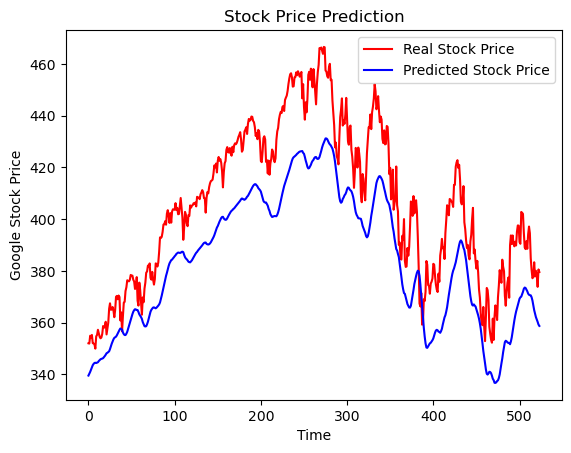

In [382]:
plt.plot(original, color = 'red', label = 'Real Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [448]:
original.shape

(523,)

In [13]:
def mean_squared_error(actual, predicted):
    n = len(actual)
    mse = np.sum((actual - predicted) ** 2) / n
    return mse

In [14]:
def best_param(df):
    test_split=round(len(df)*0.20)
    train_data=df[:-test_split]
    test_data=df[-test_split:]
    train_x=train_data.iloc[:,1:]
    train_y=train_data.iloc[:,0]
    test_x=test_data.iloc[:,1:] 
    test_y=test_data.iloc[:,0]
    def objective(trial):
        params = {
            'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 11, 333),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'max_depth': trial.suggest_int('max_depth', 5, 64),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.005, 0.1]),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
            'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
            'cat_smooth' : trial.suggest_int('cat_smooth', 10, 100),
            'cat_l2': trial.suggest_int('cat_l2', 1, 20),
            'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
            'cat_feature' : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 
                             32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 
                             53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
            'n_jobs' : -1, 
            'random_state': 42,
            'boosting_type': 'gbdt',
            'metric': 'l2',
        }
        model = LGBMRegressor(**params)  
        model.fit(train_x,train_y,eval_set=[(test_x,test_y)],eval_metric='l2', early_stopping_rounds=300, verbose=False)
        preds = model.predict(test_x)
        # 计算MSE
        test_mse = mean_squared_error(test_y, preds)

        return test_mse
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1)
    return study

In [437]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))



reg_alpha: 2.071515389976131
reg_lambda: 9.43121470066644
num_leaves: 252
min_child_samples: 12
max_depth: 59
learning_rate: 0.02
colsample_bytree: 0.4767931476299877
n_estimators: 2529
cat_smooth: 64
cat_l2: 10
min_data_per_group: 152


In [53]:
### CREATE X,Y ####
def light_create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

(156900,)

In [ ]:
### HYPERPARAMETERS ###
window_size = 365
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = 30
split_time = len(series) - test_size

train_series = series[:split_time]
test_series = series[split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

In [129]:
def Light_train(df,study):
    best_trial = study.best_trial
    test_split=round(len(df)*0.20)
    train_data=df[30:-test_split]
    test_data=df[-test_split+30:]
    train_x=train_data.iloc[:,1:]
    train_y=train_data.iloc[:,0]
    test_x=test_data.iloc[:,1:] 
    test_y=test_data.iloc[:,0]
    # train_data,test_data=train_test_split(df,test_size=0.3)
    # test_data,last_data=train_test_split(test_data,test_size=2/3)
    # train_data=np.log(abs(train_data)+1)
    # test_data=np.log(abs(test_data)+1)
#     train_data1=train_data.reset_index(drop=True)
#     valid_data1=test_data.reset_index(drop=True)
    # last_data=last_data.reset_index(drop=True)

    lgb_train = lgb.Dataset(train_x, train_y)  
    lgb_eval = lgb.Dataset(test_x, test_y, reference=lgb_train)
    evals_result = {}
    params = {
             'objective' : 'regression',
            'reg_alpha': best_trial.params['reg_alpha'],
            'reg_lambda': best_trial.params['reg_lambda'],
            'num_leaves': best_trial.params['num_leaves'],
            'min_child_samples': best_trial.params['min_child_samples'],
            'max_depth': best_trial.params['max_depth'],
            'learning_rate': best_trial.params['learning_rate'],
            'colsample_bytree': best_trial.params['colsample_bytree'],
            'n_estimators': best_trial.params['n_estimators'],
            'cat_smooth' : best_trial.params['cat_smooth'],
            'cat_l2': best_trial.params['cat_l2'],
            'min_data_per_group': 152,
            'cat_feature' : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 
                             32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 
                             53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
            'n_jobs' : -1, 
            'random_state': 42,
            'boosting_type': 'gbdt',
            'metric': {'l2','rmse'},
        }

    # Add verbosity=2 to print messages while running boosting  
    my_model = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets=lgb_eval, early_stopping_rounds=100,evals_result=evals_result)  

    lgb_predictions = my_model.predict(test_x, num_iteration=my_model.best_iteration)  
    return lgb_predictions

In [16]:
def weight(df,pred):
#     test_split=round(len(df)*0.20)
#     train_data=df[:-test_split]
#     test_data=df[-test_split:]
#     train_x=train_data.iloc[:,1:]
#     train_y=train_data.iloc[:,0]
#     test_x=test_data.iloc[:,1:] 
#     test_y=test_data.iloc[:,0]
    minmse=np.inf
    mini=0
    minj=0
    study=best_param(df)
    predict=Light_train(df,study)
    for i in range(0,10):
        for j in range (0,10):
            weight_prediction=0.1*i*pred+0.1*j*predict
            mse=mean_squared_error(weight_prediction,original)
            if mse<minmse:
                minmse=mse
                mini=i
                minj=j
    weight_prediction=mini*0.1*pred+minj*0.1*predict
    return weight_prediction

In [443]:
test_split=round(len(df)*0.20)
train_data=df[29:-test_split]
test_data=df[-test_split+29:]
train_x=train_data.iloc[:,1:]
train_y=train_data.iloc[:,0]
test_x=test_data.iloc[:,1:] 
test_y=test_data.iloc[:,0]

In [446]:
test_x

,SPYt,SPYt1,SPYt2,SPYt3,SMA5,SMA10,SMA20,SMA50,USD_JPY,LSTM
2020-12-02,0.002107,0.010936,-0.004412,-0.004412,349.570,346.582,343.3415,332.0480,104.40,275.694458
2020-12-03,-0.000284,0.002107,0.010936,0.010936,350.344,347.581,344.4525,332.8934,103.83,276.211975
2020-12-04,0.008638,-0.000284,0.002107,0.002107,351.532,348.740,345.3935,333.7832,104.14,276.506073
2020-12-07,-0.002057,0.008638,-0.000284,-0.000284,352.882,350.061,346.3020,334.5580,104.06,276.568573
2020-12-08,0.002908,-0.002057,0.008638,0.008638,353.678,351.281,347.0510,335.2486,104.15,276.463959
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.005743,-0.014269,0.014959,0.014959,379.222,384.734,389.4285,383.3890,132.79,340.874329
2022-12-27,-0.003947,0.005743,-0.014269,-0.014269,379.496,383.173,388.7980,383.8932,133.48,342.022247
2022-12-28,-0.012416,-0.003947,0.005743,0.005743,378.726,380.843,387.9660,384.1218,134.47,342.603424
2022-12-29,0.018002,-0.012416,-0.003947,-0.003947,378.172,379.440,386.8555,384.3998,133.01,343.003937


In [130]:
%time
weight_prediction=weight(df,pred)

CPU times: total: 0 ns
Wall time: 0 ns


NameError: name 'pred' is not defined

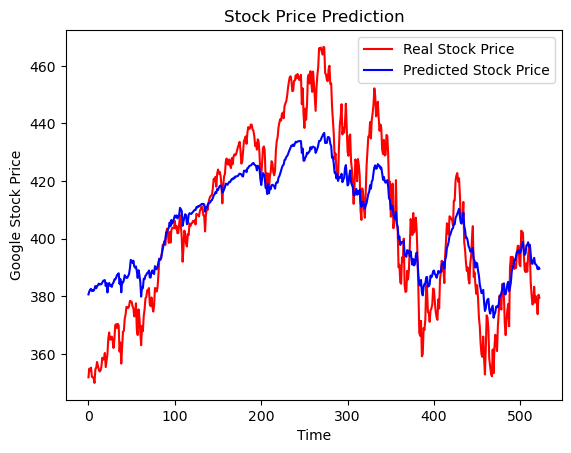

In [453]:
plt.plot(original, color = 'red', label = 'Real Stock Price')
plt.plot(weight_prediction, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [454]:
plot_optimization_history(study)


In [455]:
df.drop('LSTM', axis=1, inplace=True)

In [456]:
def new_variable(df,prediction):
    df_new_variable=df.insert(len(df.columns),'LSTM',prediction)
    
    study=best_param(df)
    predict=Light_train(df,study)
    return predict

In [457]:
%time
lgb_predictions=new_variable(df,lstm_pred)

[I 2023-07-29 05:32:29,331] A new study created in memory with name: no-name-19214db7-e13e-4700-be4c-5ced88bd6099


CPU times: total: 0 ns
Wall time: 0 ns


[I 2023-07-29 05:32:30,859] Trial 0 finished with value: 6517.423150326007 and parameters: {'reg_alpha': 8.207085991175925, 'reg_lambda': 3.740514278497977, 'num_leaves': 273, 'min_child_samples': 55, 'max_depth': 29, 'learning_rate': 0.05, 'colsample_bytree': 0.4259017023609898, 'n_estimators': 2322, 'cat_smooth': 28, 'cat_l2': 13, 'min_data_per_group': 180}. Best is trial 0 with value: 6517.423150326007.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2182, number of used features: 10
[LightGBM] [Info] Start training from score 201.329606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l2: 40482.7
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l2: 38497.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l2: 36693.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l2: 34975.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l2: 33361.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's l2: 7490.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	valid_0's l2: 7487.23
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	valid_0's l2: 7492.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0's l2: 7492.02
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	valid_0's l2: 7491.18
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[196]	valid_0's l2: 7489.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[197]	valid_0's l2: 7487.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[198]	valid_0's l2: 7487.09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's l2: 7487.09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2

[346]	valid_0's l2: 7349.84
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[347]	valid_0's l2: 7348.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[348]	valid_0's l2: 7348.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[349]	valid_0's l2: 7348.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	valid_0's l2: 7346.61
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	valid_0's l2: 7346.72
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[352]	valid_0's l2: 7342.11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[353]	valid_0's l2: 7341.03
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[354]	valid_0's l2: 7338.74
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	valid_0's l2: 7338.67
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[536]	valid_0's l2: 7222.32
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	valid_0's l2: 7222.28
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	valid_0's l2: 7222.28
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	valid_0's l2: 7222.58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	valid_0's l2: 7222.58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	valid_0's l2: 7222.58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	valid_0's l2: 7220.86
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	valid_0's l2: 7220.88
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	valid_0's l2: 7218.63
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[779]	valid_0's l2: 7101.64
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[780]	valid_0's l2: 7098.73
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[781]	valid_0's l2: 7098.73
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[782]	valid_0's l2: 7097.69
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[783]	valid_0's l2: 7097.19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[784]	valid_0's l2: 7096.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[785]	valid_0's l2: 7095.07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[786]	valid_0's l2: 7093.11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[787]	valid_0's l2: 7093.05
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1033]	valid_0's l2: 7014.94
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1034]	valid_0's l2: 7014.94
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1035]	valid_0's l2: 7013.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1036]	valid_0's l2: 7013.33
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1037]	valid_0's l2: 7013.56
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1038]	valid_0's l2: 7013.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1039]	valid_0's l2: 7012.42
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1040]	valid_0's l2: 7012.62
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1041]	valid_0's l2: 7012.62
[LightGBM] [Warning] No further splits with positive gain, best ga

[1296]	valid_0's l2: 6971.27
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1297]	valid_0's l2: 6970.23
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1298]	valid_0's l2: 6970.36
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1299]	valid_0's l2: 6970.42
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1300]	valid_0's l2: 6970.35
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1301]	valid_0's l2: 6969.89
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1302]	valid_0's l2: 6969.77
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1303]	valid_0's l2: 6969.83
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1304]	valid_0's l2: 6969.89
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1305]	valid_0's l2: 6968.92
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1609]	valid_0's l2: 6949.59
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1610]	valid_0's l2: 6949.48
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1611]	valid_0's l2: 6949.45
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1612]	valid_0's l2: 6949.45
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1613]	valid_0's l2: 6949.45
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1614]	valid_0's l2: 6948.18
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1615]	valid_0's l2: 6948.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1616]	valid_0's l2: 6948.23
[LightGBM] [Warning] No further splits with positive gain, best g

In [462]:
mean_squared_error(weight_prediction,original)

192.592187144723

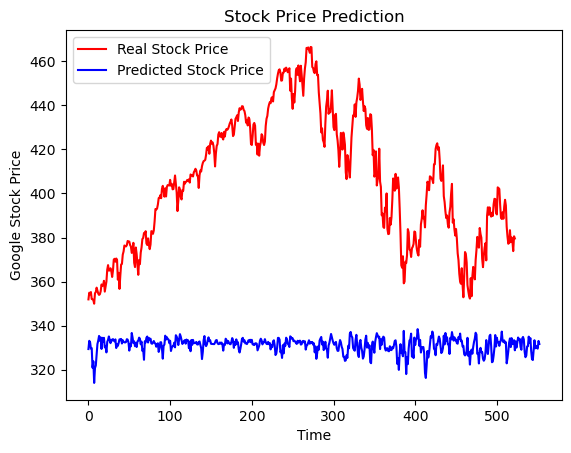

In [478]:

plt.plot(original, color = 'red', label = 'Real Stock Price')
plt.plot(lgb_predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

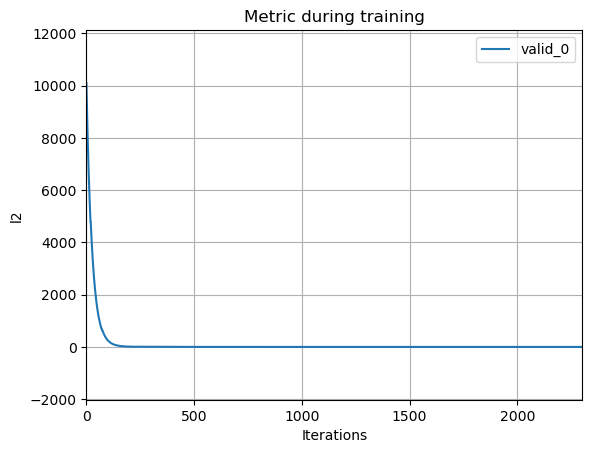

In [438]:
ax = lgb.plot_metric(evals_result, metric='l2')
plt.show()

In [48]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
train,test=df_split(df)
trainX,trainY=createXY(train,30)
testX,testY=createXY(test,30)

(523, 30, 10)

In [82]:
test_y

4230    255.03
4231    253.88
4232    252.59
4233    244.94
4234    249.33
         ...  
5282    380.04
5283    378.54
5284    373.84
5285    380.57
5286    379.57
Name: Close, Length: 1057, dtype: float64

In [114]:
sequence_length = 30  # Define the length of input sequences
test_split=round(len(df)*0.20)
train_data=df[:-test_split]
test_data=df[-test_split:]
rain_data=np.log(abs(train_data)+1)
test_data=np.log(abs(test_data)+1)
train_data=train_data.reset_index(drop=True)
test_data=test_data.reset_index(drop=True)
# Function to create sequential samples from the data
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    num_samples = len(X)
    for i in range(num_samples - sequence_length):
        X_seq.append(X.iloc[i:i+sequence_length].values.reshape(-1))  # Flatten the sequence
        y_seq.append(y[i+sequence_length])
    return np.array(X_seq), np.array(y_seq)
train_x=train_data.iloc[:,1:]
train_y=train_data.iloc[:,0]
test_x=test_data.iloc[:,1:] 
test_y=test_data.iloc[:,0]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
X_train_seq, y_train_seq = create_sequences(train_x, train_y, sequence_length)
X_test_seq, y_test_seq = create_sequences(test_x, test_y, sequence_length)
print(X_train_seq.shape)
print(y_train_seq.shape)
print(X_test_seq.shape)
print(y_test_seq.shape)

(4230, 8)
(4230,)
(1057, 8)
(1057,)
(4200, 240)
(4200,)
(1027, 240)
(1027,)


In [110]:
window_size = 0
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = 60
split_time = len(df) - test_size

train_series = df[:split_time]
test_series = df[split_time - window_size:]

train_x, train_y = light_create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = light_create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(5227, 0, 9)
(47043,)
(60, 0, 9)
(540,)


In [118]:
df['lag1']=df['Close'].shift(1)
df['lag2']=df['Close'].shift(2)

In [122]:
df['lag3']=df['Close'].shift(3)
df['lag4']=df['Close'].shift(4)
df['lag5']=df['Close'].shift(5)
df['lag6']=df['Close'].shift(6)
df['lag7']=df['Close'].shift(7)
df['lag8']=df['Close'].shift(8)
df['lag9']=df['Close'].shift(9)
df['lag10']=df['Close'].shift(10)


In [131]:
test_split=round(len(df)*0.20)
train_data=df[:-test_split]
test_data=df[-test_split:]

# train_data,test_data=train_test_split(df,test_size=0.3)
# test_data,last_data=train_test_split(test_data,test_size=2/3)
# rain_data=np.log(abs(train_data)+1)
# test_data=np.log(abs(test_data)+1)
# last_data=last_data.reset_index(drop=True)
train_x=train_data.iloc[:,1:]
train_y=train_data.iloc[:,0]
test_x=test_data.iloc[:,1:] 
test_y=test_data.iloc[:,0]
# lgb_train = lgb.Dataset(X_train_seq, label=y_train_seq.reshape(-1, 1))  # Make y_train_seq 2D
# lgb_eval = lgb.Dataset(X_test_seq, label=y_test_seq.reshape(-1, 1)) 
lgb_train = lgb.Dataset(train_x, train_y)  
lgb_eval = lgb.Dataset(test_x, test_y, reference=lgb_train)
evals_result = {}
params = {  
'boosting_type': 'gbdt',                       # 设置提升类型  
'objective': 'regression',                 # 目标函数  
'metric': {'l2,rmse,mae'},              # 评估函数  
'verbose': 1                          #  <0 显示致命的, =0 显示错误 (警告), >0 显示信息  
}  
# Add verbosity=2 to print messages while running boosting  
#my_model = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets=lgb_eval, early_stopping_rounds=1000,evals_result=evals_result)  
my_model = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets=lgb_eval, early_stopping_rounds=1000,evals_result=evals_result)  

lgb_predictions = my_model.predict(test_x, num_iteration=my_model.best_iteration)  

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 4230, number of used features: 18
[LightGBM] [Info] Start training from score 122.109619
[1]	valid_0's l2: 47583.4	valid_0's rmse: 218.136	valid_0's l1: 207.385
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l2: 42440.9	valid_0's rmse: 206.012	valid_0's l1: 194.689
[3]	valid_0's l2: 38040.7	valid_0's rmse: 195.04	valid_0's l1: 183.145
[4]	valid_0's l2: 34346.6	valid_0's rmse: 185.328	valid_0's l1: 172.852
[5]	valid_0's l2: 31168	valid_0's rmse: 176.545	valid_0's l1: 163.493
[6]	valid_0's l2: 28457.2	valid_0's rmse: 168.692	valid_0's l1: 155.069
[7]	valid_0's l2: 26181.3	valid_0's rmse: 161.806	valid_0's l1: 147.612
[8]	valid_0's l2: 24210.7	valid_0's rmse: 155.598	valid_0's l1: 140.847
[9]	valid_0's l2: 

[125]	valid_0's l2: 10504.7	valid_0's rmse: 102.493	valid_0's l1: 79.7411
[126]	valid_0's l2: 10505.9	valid_0's rmse: 102.498	valid_0's l1: 79.7466
[127]	valid_0's l2: 10505.1	valid_0's rmse: 102.494	valid_0's l1: 79.7418
[128]	valid_0's l2: 10505.7	valid_0's rmse: 102.497	valid_0's l1: 79.7449
[129]	valid_0's l2: 10504.2	valid_0's rmse: 102.49	valid_0's l1: 79.7376
[130]	valid_0's l2: 10502.8	valid_0's rmse: 102.483	valid_0's l1: 79.7299
[131]	valid_0's l2: 10501.5	valid_0's rmse: 102.477	valid_0's l1: 79.7234
[132]	valid_0's l2: 10502.7	valid_0's rmse: 102.482	valid_0's l1: 79.7288
[133]	valid_0's l2: 10501.4	valid_0's rmse: 102.476	valid_0's l1: 79.7226
[134]	valid_0's l2: 10500.6	valid_0's rmse: 102.473	valid_0's l1: 79.7184
[135]	valid_0's l2: 10501.6	valid_0's rmse: 102.477	valid_0's l1: 79.723
[136]	valid_0's l2: 10502.6	valid_0's rmse: 102.482	valid_0's l1: 79.728
[137]	valid_0's l2: 10501.4	valid_0's rmse: 102.476	valid_0's l1: 79.7216
[138]	valid_0's l2: 10502.5	valid_0's rms

[243]	valid_0's l2: 10496.5	valid_0's rmse: 102.453	valid_0's l1: 79.6882
[244]	valid_0's l2: 10497.2	valid_0's rmse: 102.456	valid_0's l1: 79.6915
[245]	valid_0's l2: 10497.9	valid_0's rmse: 102.459	valid_0's l1: 79.6951
[246]	valid_0's l2: 10498.5	valid_0's rmse: 102.462	valid_0's l1: 79.6982
[247]	valid_0's l2: 10497.8	valid_0's rmse: 102.459	valid_0's l1: 79.6944
[248]	valid_0's l2: 10497.7	valid_0's rmse: 102.458	valid_0's l1: 79.6942
[249]	valid_0's l2: 10497.1	valid_0's rmse: 102.455	valid_0's l1: 79.6908
[250]	valid_0's l2: 10497.6	valid_0's rmse: 102.458	valid_0's l1: 79.6939
[251]	valid_0's l2: 10497	valid_0's rmse: 102.455	valid_0's l1: 79.6905
[252]	valid_0's l2: 10497.6	valid_0's rmse: 102.458	valid_0's l1: 79.6937
[253]	valid_0's l2: 10498.2	valid_0's rmse: 102.461	valid_0's l1: 79.6968
[254]	valid_0's l2: 10497.5	valid_0's rmse: 102.457	valid_0's l1: 79.6933
[255]	valid_0's l2: 10498.2	valid_0's rmse: 102.461	valid_0's l1: 79.6964
[256]	valid_0's l2: 10497.5	valid_0's rm

[361]	valid_0's l2: 10497.6	valid_0's rmse: 102.458	valid_0's l1: 79.6913
[362]	valid_0's l2: 10497.1	valid_0's rmse: 102.456	valid_0's l1: 79.6889
[363]	valid_0's l2: 10496.5	valid_0's rmse: 102.453	valid_0's l1: 79.6857
[364]	valid_0's l2: 10496.9	valid_0's rmse: 102.455	valid_0's l1: 79.6878
[365]	valid_0's l2: 10497.4	valid_0's rmse: 102.457	valid_0's l1: 79.69
[366]	valid_0's l2: 10497.8	valid_0's rmse: 102.459	valid_0's l1: 79.6921
[367]	valid_0's l2: 10497.3	valid_0's rmse: 102.456	valid_0's l1: 79.6896
[368]	valid_0's l2: 10497.4	valid_0's rmse: 102.457	valid_0's l1: 79.6899
[369]	valid_0's l2: 10496.9	valid_0's rmse: 102.454	valid_0's l1: 79.6874
[370]	valid_0's l2: 10497.3	valid_0's rmse: 102.456	valid_0's l1: 79.6894
[371]	valid_0's l2: 10496.8	valid_0's rmse: 102.454	valid_0's l1: 79.687
[372]	valid_0's l2: 10496.2	valid_0's rmse: 102.451	valid_0's l1: 79.6837
[373]	valid_0's l2: 10496.7	valid_0's rmse: 102.453	valid_0's l1: 79.6861
[374]	valid_0's l2: 10497.1	valid_0's rms

[486]	valid_0's l2: 10497.8	valid_0's rmse: 102.459	valid_0's l1: 79.6903
[487]	valid_0's l2: 10497.4	valid_0's rmse: 102.457	valid_0's l1: 79.6884
[488]	valid_0's l2: 10497.7	valid_0's rmse: 102.458	valid_0's l1: 79.6899
[489]	valid_0's l2: 10497.7	valid_0's rmse: 102.458	valid_0's l1: 79.6897
[490]	valid_0's l2: 10497.3	valid_0's rmse: 102.457	valid_0's l1: 79.688
[491]	valid_0's l2: 10497.7	valid_0's rmse: 102.458	valid_0's l1: 79.6896
[492]	valid_0's l2: 10497.3	valid_0's rmse: 102.456	valid_0's l1: 79.6877
[493]	valid_0's l2: 10497.6	valid_0's rmse: 102.458	valid_0's l1: 79.6891
[494]	valid_0's l2: 10497.2	valid_0's rmse: 102.456	valid_0's l1: 79.6873
[495]	valid_0's l2: 10497.5	valid_0's rmse: 102.458	valid_0's l1: 79.6889
[496]	valid_0's l2: 10497.8	valid_0's rmse: 102.459	valid_0's l1: 79.6904
[497]	valid_0's l2: 10497.5	valid_0's rmse: 102.457	valid_0's l1: 79.6885
[498]	valid_0's l2: 10497.8	valid_0's rmse: 102.459	valid_0's l1: 79.6902
[499]	valid_0's l2: 10497.4	valid_0's r

[627]	valid_0's l2: 10498.9	valid_0's rmse: 102.464	valid_0's l1: 79.6954
[628]	valid_0's l2: 10499.2	valid_0's rmse: 102.465	valid_0's l1: 79.6968
[629]	valid_0's l2: 10498.8	valid_0's rmse: 102.464	valid_0's l1: 79.695
[630]	valid_0's l2: 10498.5	valid_0's rmse: 102.462	valid_0's l1: 79.6936
[631]	valid_0's l2: 10498.2	valid_0's rmse: 102.461	valid_0's l1: 79.692
[632]	valid_0's l2: 10498.5	valid_0's rmse: 102.462	valid_0's l1: 79.6936
[633]	valid_0's l2: 10498.8	valid_0's rmse: 102.464	valid_0's l1: 79.6949
[634]	valid_0's l2: 10498.5	valid_0's rmse: 102.462	valid_0's l1: 79.6935
[635]	valid_0's l2: 10498.8	valid_0's rmse: 102.464	valid_0's l1: 79.695
[636]	valid_0's l2: 10499.1	valid_0's rmse: 102.465	valid_0's l1: 79.6964
[637]	valid_0's l2: 10498.7	valid_0's rmse: 102.463	valid_0's l1: 79.6946
[638]	valid_0's l2: 10498.4	valid_0's rmse: 102.462	valid_0's l1: 79.693
[639]	valid_0's l2: 10498.7	valid_0's rmse: 102.463	valid_0's l1: 79.6944
[640]	valid_0's l2: 10499	valid_0's rmse: 

[753]	valid_0's l2: 10500.4	valid_0's rmse: 102.471	valid_0's l1: 79.7029
[754]	valid_0's l2: 10500.6	valid_0's rmse: 102.473	valid_0's l1: 79.7041
[755]	valid_0's l2: 10500.3	valid_0's rmse: 102.471	valid_0's l1: 79.7025
[756]	valid_0's l2: 10500.1	valid_0's rmse: 102.47	valid_0's l1: 79.7013
[757]	valid_0's l2: 10500.3	valid_0's rmse: 102.471	valid_0's l1: 79.7026
[758]	valid_0's l2: 10500.1	valid_0's rmse: 102.47	valid_0's l1: 79.7014
[759]	valid_0's l2: 10500.4	valid_0's rmse: 102.471	valid_0's l1: 79.7028
[760]	valid_0's l2: 10500.6	valid_0's rmse: 102.472	valid_0's l1: 79.704
[761]	valid_0's l2: 10500.3	valid_0's rmse: 102.471	valid_0's l1: 79.7024
[762]	valid_0's l2: 10499.8	valid_0's rmse: 102.468	valid_0's l1: 79.6997
[763]	valid_0's l2: 10500	valid_0's rmse: 102.47	valid_0's l1: 79.7011
[764]	valid_0's l2: 10500.3	valid_0's rmse: 102.471	valid_0's l1: 79.7023
[765]	valid_0's l2: 10500	valid_0's rmse: 102.47	valid_0's l1: 79.701
[766]	valid_0's l2: 10500.3	valid_0's rmse: 102.

[940]	valid_0's l2: 10501.8	valid_0's rmse: 102.478	valid_0's l1: 79.7099
[941]	valid_0's l2: 10501.5	valid_0's rmse: 102.477	valid_0's l1: 79.7088
[942]	valid_0's l2: 10501.8	valid_0's rmse: 102.478	valid_0's l1: 79.7099
[943]	valid_0's l2: 10501.5	valid_0's rmse: 102.477	valid_0's l1: 79.7089
[944]	valid_0's l2: 10501.8	valid_0's rmse: 102.478	valid_0's l1: 79.71
[945]	valid_0's l2: 10502	valid_0's rmse: 102.479	valid_0's l1: 79.7111
[946]	valid_0's l2: 10501.7	valid_0's rmse: 102.478	valid_0's l1: 79.7099
[947]	valid_0's l2: 10502	valid_0's rmse: 102.479	valid_0's l1: 79.7111
[948]	valid_0's l2: 10502.2	valid_0's rmse: 102.48	valid_0's l1: 79.7121
[949]	valid_0's l2: 10502	valid_0's rmse: 102.479	valid_0's l1: 79.711
[950]	valid_0's l2: 10502.2	valid_0's rmse: 102.48	valid_0's l1: 79.7123
[951]	valid_0's l2: 10501.9	valid_0's rmse: 102.479	valid_0's l1: 79.7109
[952]	valid_0's l2: 10502.1	valid_0's rmse: 102.48	valid_0's l1: 79.712
[953]	valid_0's l2: 10501.9	valid_0's rmse: 102.479

In [132]:
lgb_predictions

array([255.70286893, 254.57954473, 254.35546696, ..., 262.36519302,
       266.96198998, 265.97647272])

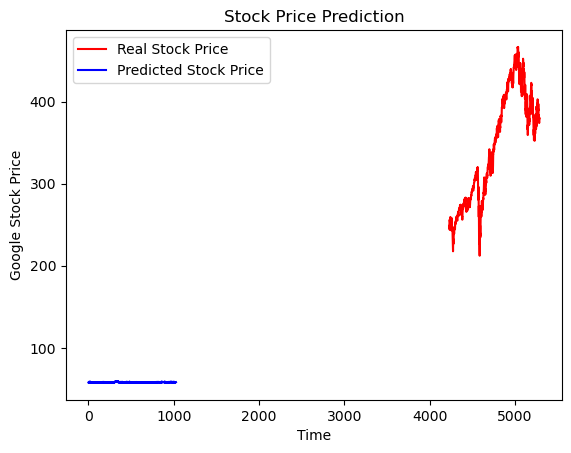

In [117]:

plt.plot(test_y, color = 'red', label = 'Real Stock Price')
plt.plot(lgb_predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()